In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import RMSprop, Adam
import matplotlib.pyplot as plt


In [ ]:
df=pd.read_csv('/BAJAJFINSV.csv')

In [ ]:
df.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2011-06-01,BAJAJFINSV,EQ,518.40,521.8,528.95,517.1,521.10,521.05,522.81,113360,5.926609e+12,4155.0,34098,0.3008
1,2011-06-02,BAJAJFINSV,EQ,521.05,518.8,519.85,504.0,514.95,512.45,513.71,62967,3.234650e+12,2437.0,21069,0.3346
2,2011-06-03,BAJAJFINSV,EQ,512.45,512.5,520.00,506.0,507.10,508.40,513.11,36445,1.870040e+12,1754.0,10702,0.2936
3,2011-06-06,BAJAJFINSV,EQ,508.40,508.0,508.00,496.0,502.25,502.25,501.92,33537,1.683281e+12,1346.0,14215,0.4239
4,2011-06-07,BAJAJFINSV,EQ,502.25,503.0,552.00,503.0,546.50,545.50,536.79,1237385,6.642112e+13,36245.0,216387,0.1749


In [ ]:
df.columns.isna()

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False])

In [ ]:
df.iloc[:, 4:9]

,Open,High,Low,Last,Close
0,521.8,528.95,517.10,521.10,521.05
1,518.8,519.85,504.00,514.95,512.45
2,512.5,520.00,506.00,507.10,508.40
3,508.0,508.00,496.00,502.25,502.25
4,503.0,552.00,503.00,546.50,545.50
...,...,...,...,...,...
2451,9992.0,10125.00,9902.20,10000.85,10001.75
2452,10000.0,10133.00,9964.70,10133.00,10091.35
2453,10200.0,10615.95,10151.15,10480.00,10489.30
2454,10540.0,11300.00,10520.00,11175.45,11176.55


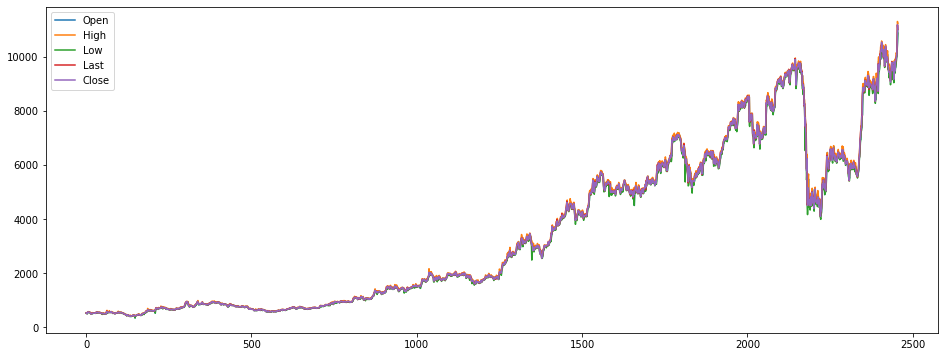

In [ ]:
df[['Open','High','Low','Last','Close']].plot(figsize=(16,6))

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle_buffer > 0:
        ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
train, val = train_test_split(df.iloc[:, 4:9], test_size=0.2, shuffle=False)
scaler = MinMaxScaler().fit(train)
train = scaler.transform(train)[:, 0]
val = scaler.transform(val)[:, 0]
train = windowed_dataset(train, window_size=8, batch_size=32, shuffle_buffer=20)
val = windowed_dataset(val, window_size=8, batch_size=32, shuffle_buffer=20)

In [ ]:
model= Sequential()
model.add(LSTM(70, return_sequences=True, activation='relu')) #input_shape=)
model.add(LSTM(70,activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))

In [ ]:
model.compile(loss='mse',optimizer=Adam(lr=0.001), metrics=['mae'])

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
callback = EarlyStopping(monitor='val_loss', patience=5, mode='auto')
history = model.fit(train, epochs=30,validation_data=val)

Epoch 1/30
62/62 [==============================] - 5s 29ms/step - loss: 0.0038 - mae: 0.0457 - val_loss: 0.0247 - val_mae: 0.1329
Epoch 2/30
62/62 [==============================] - 1s 16ms/step - loss: 0.0249 - mae: 0.1243 - val_loss: 0.0078 - val_mae: 0.0672
Epoch 3/30
62/62 [==============================] - 1s 16ms/step - loss: 0.0403 - mae: 0.1636 - val_loss: 0.0381 - val_mae: 0.1799
Epoch 4/30
62/62 [==============================] - 1s 16ms/step - loss: 0.0244 - mae: 0.1305 - val_loss: 0.0051 - val_mae: 0.0508
Epoch 5/30
62/62 [==============================] - 1s 15ms/step - loss: 0.0122 - mae: 0.0921 - val_loss: 0.0164 - val_mae: 0.1005
Epoch 6/30
62/62 [==============================] - 1s 16ms/step - loss: 0.0104 - mae: 0.0797 - val_loss: 0.0205 - val_mae: 0.1301
Epoch 7/30
62/62 [==============================] - 1s 16ms/step - loss: 0.0084 - mae: 0.0754 - val_loss: 0.0046 - val_mae: 0.0473
Epoch 8/30
62/62 [==============================] - 1s 15ms/step - loss: 0.0043 - m

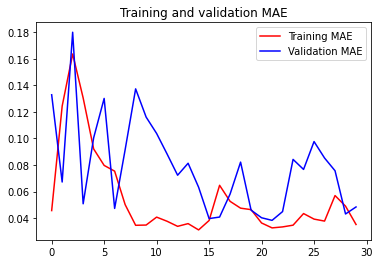

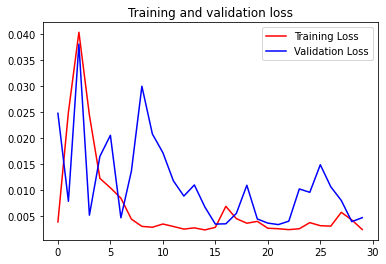

In [ ]:
acc = history.history['mae']
val_acc = history.history['val_mae']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training MAE')
plt.plot(epochs, val_acc, 'b', label='Validation MAE')
plt.title('Training and validation MAE')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()